In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

from src.nn.MDN import MDN, mdn_loss
from src.nn.MLP import MLP

In [2]:
def generate_simple_data(n_samples):
    epsilon = np.random.normal(size=(n_samples)) # sample noise from Gaussin dist with mean 0, std = 1.0
    x = np.random.uniform(-10.5, 10.5, n_samples)
    y = 7 * np.sin(0.75 * x) + 0.5 * x + epsilon
    return x, y

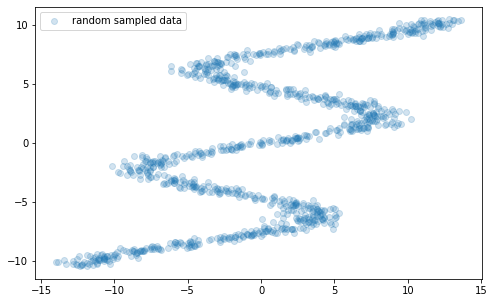

In [4]:
y, x = generate_simple_data(1000) # just swap x,y to generate 'many-to-one' mapping

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(x,y, alpha=0.2, label='random sampled data')
plt.legend()
plt.show()

In [6]:
from src.nn.GaussianNet import GaussianNetwork, gaussianLL

In [9]:
gaussianNet = GaussianNetwork(1, 100, 1)

opt = torch.optim.Adam(gaussianNet.parameters())
x_tensor = torch.tensor(x).reshape(-1, 1).float()
y_tensor = torch.tensor(y).reshape(-1, 1).float()

## Visualizing the NOT trained model

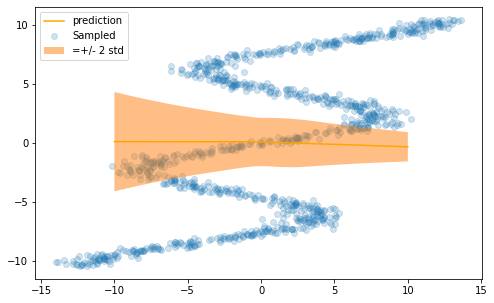

In [11]:
_x_tensor = torch.linspace(-10, 10, 100).reshape(-1,1)
mu, std = gaussianNet(_x_tensor)
N_STD = 2

x_axis = np.squeeze(_x_tensor.detach().numpy())
upper = mu + N_STD *std
upper_np = np.squeeze(upper.detach().numpy())

lower = mu - N_STD * std
lower_np = np.squeeze(lower.detach().numpy())

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(x, y, alpha=0.2, label='Sampled')
ax.plot(x_axis, mu.detach().numpy(), color='orange', label='prediction')
ax.fill_between(x_axis, upper_np, lower_np, alpha=0.5, label='=+/- {} std'.format(N_STD))
plt.legend()
plt.show()

In [13]:
 for i in tqdm(range(1500)):
    mu, std = gaussianNet(x_tensor)
    loss = gaussianLL(mu, std, y_tensor)
    loss = -loss.mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

100%|█████████████████████████████████████████████████████████████| 1500/1500 [00:06<00:00, 244.84it/s]


## Gaussian network is not capable of fitting multimodal outcomes


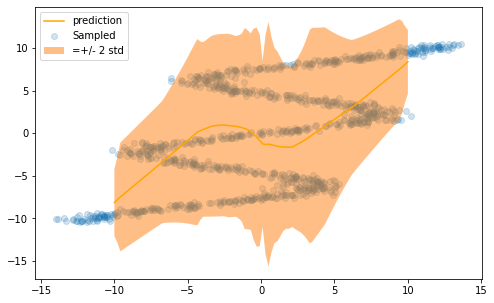

In [14]:
_x_tensor = torch.linspace(-10, 10, 100).reshape(-1,1)
mu, std = gaussianNet(_x_tensor)
N_STD = 2

x_axis = np.squeeze(_x_tensor.detach().numpy())
upper = mu + N_STD *std
upper_np = np.squeeze(upper.detach().numpy())

lower = mu - N_STD * std
lower_np = np.squeeze(lower.detach().numpy())

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(x, y, alpha=0.2, label='Sampled')
ax.plot(x_axis, mu.detach().numpy(), color='orange', label='prediction')
ax.fill_between(x_axis, upper_np, lower_np, alpha=0.5, label='=+/- {} std'.format(N_STD))
plt.legend()
plt.show()

## Quick fix: Mixture Density Network

In [34]:
device = 'cuda:0'

mdn = nn.Sequential(MLP(1, 64, hidden_act='LeakyReLU'), 
                    MDN(64, 1, 5)).to(device)
opt = torch.optim.Adam(mdn.parameters())

In [35]:
x_tensor = x_tensor.to(device)
y_tensor = y_tensor.to(device)

for i in range(30000):
    pi, mu, sigma  = mdn(x_tensor)
    loss = mdn_loss(pi, mu, sigma, y_tensor)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i % 3000 == 0:
        print("[{} epoch] loss = {}".format(i, loss.item()))

[0 epoch] loss = 10.570395469665527
[3000 epoch] loss = 1.5036919116973877
[6000 epoch] loss = 1.4801266193389893
[9000 epoch] loss = 1.4328808784484863
[12000 epoch] loss = 1.4121264219284058
[15000 epoch] loss = 1.3951221704483032
[18000 epoch] loss = 1.3900564908981323
[21000 epoch] loss = 1.3803249597549438
[24000 epoch] loss = 1.373634696006775
[27000 epoch] loss = 1.3710078001022339


In [36]:
mdn.to('cpu')

x_test_data = np.linspace(-15, 15, 1000)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(1000, 1))
pi, mu, sigma = mdn(x_test_tensor)

pi_data = pi.data.numpy()
sigma_data = sigma.data.numpy()
mu_data = mu.data.numpy()

In [37]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x+1e-10) + z).argmax(axis=axis)

In [38]:
n_samples = 1000
x_test_data = np.linspace(-10, 10, n_samples)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(-1, 1))

pi, mu, sigma = mdn(x_test_tensor)

pi_data = np.squeeze(pi.data.numpy())
sigma_data = np.squeeze(sigma.data.numpy())
mu_data = np.squeeze(mu.data.numpy())

k = gumbel_sample(pi_data)

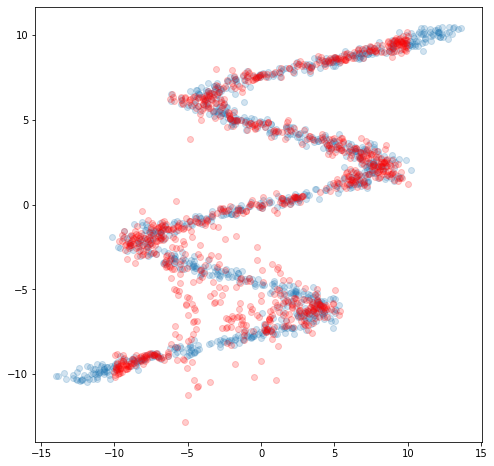

In [39]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()